## Looking at the GNN Structure

In [1]:
import sys
import os
import pandas as pd

%load_ext autoreload
%autoreload 2

# Get the absolute path of the project root (fpi_ml)
project_root = "/Users/elliotdable/Documents/PhD/research/fpi_ml"
sys.path.append(project_root)

from src.GNN.data_processing import create_data_object

fpi_path = '/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/indra/processed_fpi_data/scandinavia_2024.csv'
imf_path = '/Users/elliotdable/Documents/PhD/research/fpi_ml/data/imf_data/compiled/omni_imf_data_2010_2025_cleaned.csv'
geomag_path = '/Users/elliotdable/Documents/PhD/research/fpi_ml/data/geomag_data/solar_geomag_dst_data.csv'
target_col = 'temperature'

base_feature_cols = ['altitude', 'observation_latitude',  'observation_longitude', target_col]

imf_feature_cols = ['bx_gse_gsm', 'by_gse', 'bz_gse'] # ['datetime', 'day', 'hour', 'minute', 'bx_gse_gsm', 'by_gse', 'bz_gse',
                                                        # 'b_vector_rms_sd', 'vx_kms', 'vy_kms', 'vz_kms', 'proton_density',
                                                        #'proton_temperature', 'al_index', 'au_index']
     
geomag_feature_cols = ['ap30', 'sn', 'f30']     # 'datetime', 'hp30', 'ap30', 'ap', 
                                                #'sn', 'f30', 'f15', 'f10_7', 'f8','f3_2'
       

model_name = 'scandinavia_jan_2024'
save_path =f'/Users/elliotdable/Documents/PhD/research/fpi_ml/models/'

In [3]:
data = create_data_object(fpi_path, imf_path, geomag_path, base_feature_cols, imf_feature_cols,         
    geomag_feature_cols,save_path, model_name, num_workers=os.cpu_count(), target_col='temperature', 
                       edge_count=60, imf_hours=3, geomag_days=0.5, imf_resample='30min')

Reading datafiles to CSVs...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/elliotdable/Documents/PhD/research/fpi_ml/data/fpi_data/indra/scandinavia_jan_2024[test].csv'

In [ ]:
print(data)
print(data.x.shape)
print(data.edge_index.shape)
print(data.edge_attr.shape)
print(data.y.shape)
print(data.train_mask.shape)
print(data.val_mask.shape)
print(data.test_mask.shape)
print(data.weight.shape)

Data(x=[45384, 103], edge_index=[2, 263416], edge_attr=[263416, 5], y=[45384], train_mask=[45384], val_mask=[45384], test_mask=[45384], weight=[45384])
torch.Size([45384, 103])
torch.Size([2, 263416])
torch.Size([263416, 5])
torch.Size([45384])
torch.Size([45384])
torch.Size([45384])
torch.Size([45384])
torch.Size([45384])


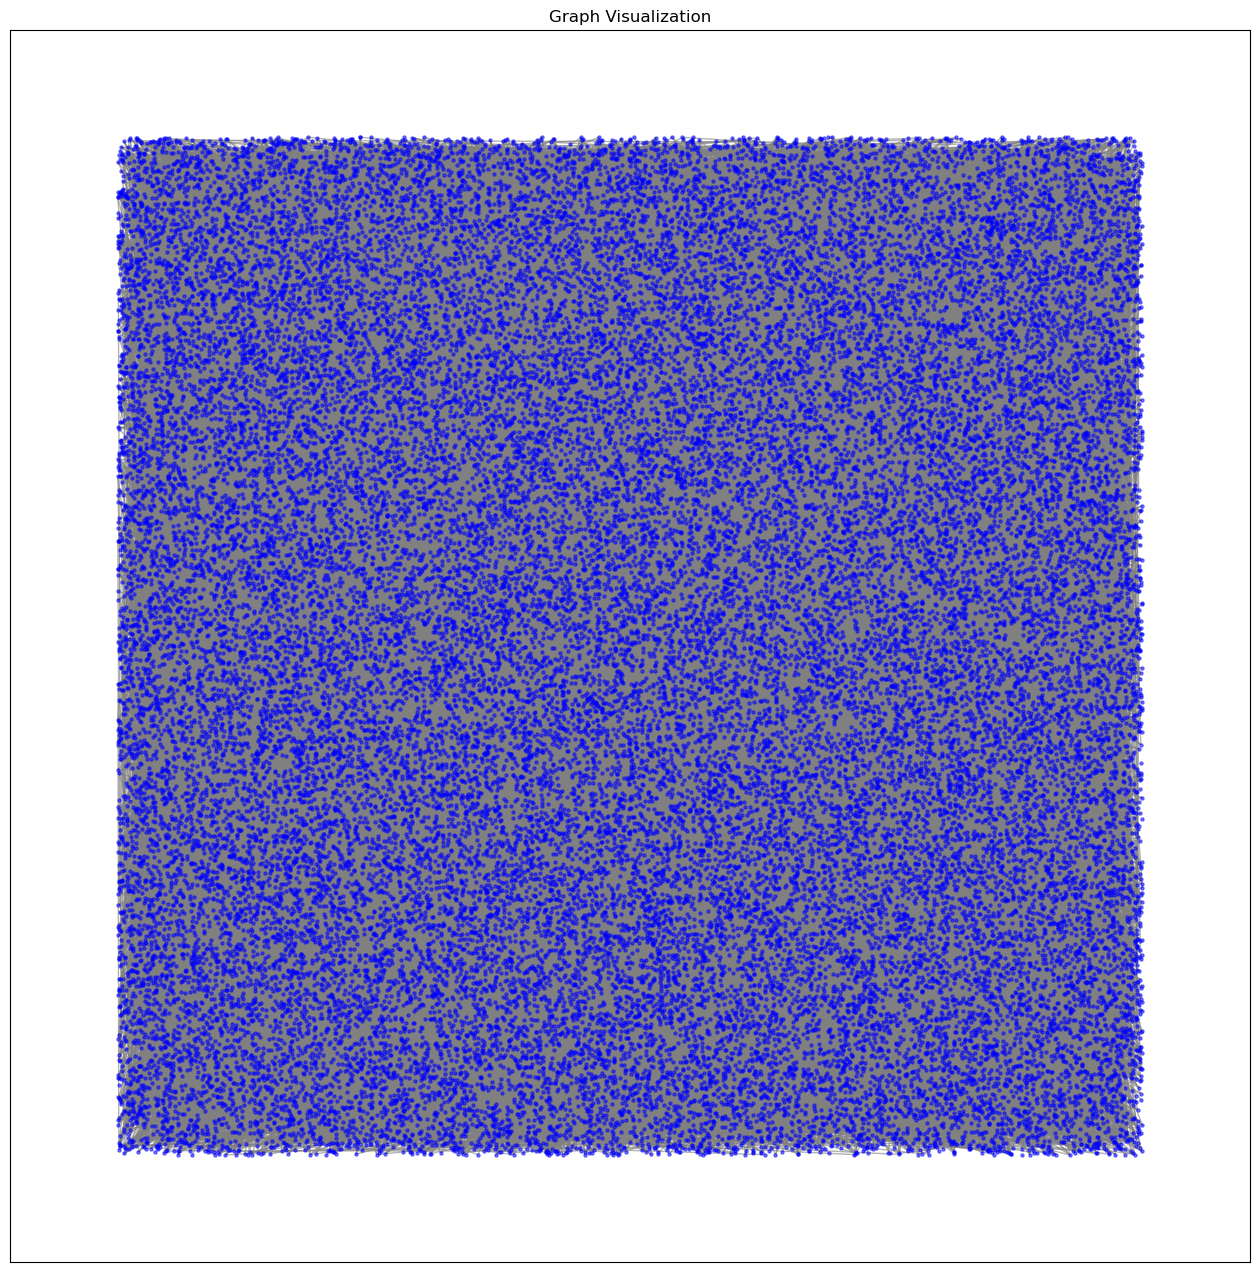

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG Data → NetworkX
G = to_networkx(data, to_undirected=True)

# Draw with labels (node index)
plt.figure(figsize=(16,16))
pos = nx.random_layout(G)  # or nx.circular_layout(G), much faster
nx.draw_networkx_nodes(G, pos, node_size=5, node_color='blue', alpha=0.5)
nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color='gray')
plt.title("Graph Visualization")
plt.show()

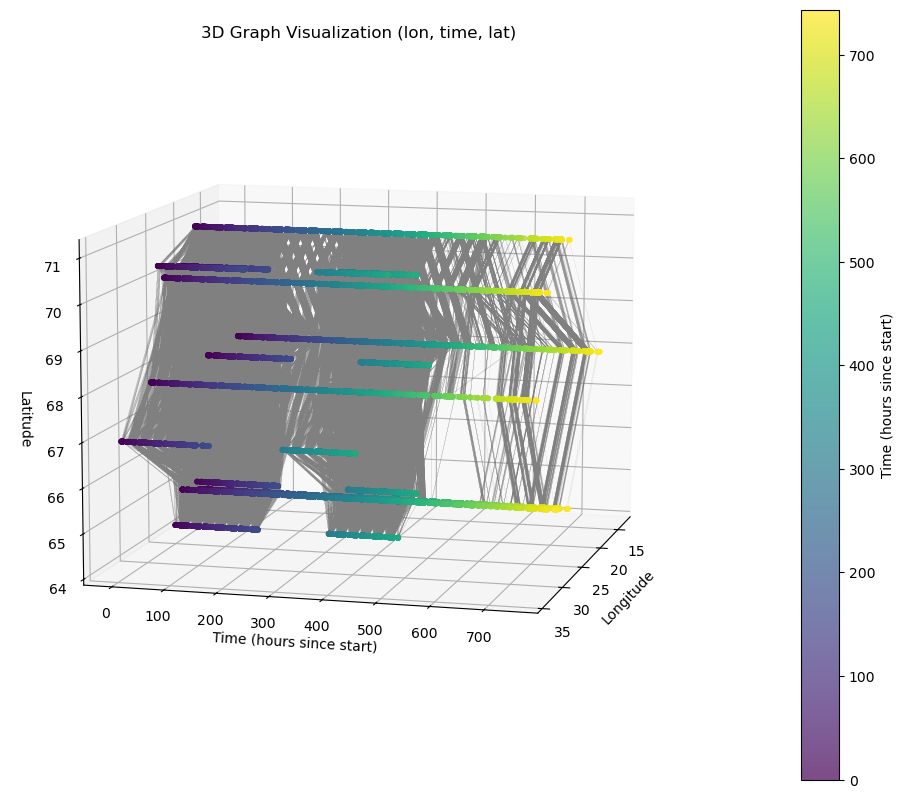

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load node data
fpi_df = pd.read_csv(fpi_path)

lat = fpi_df["observation_latitude"].values
lon = fpi_df["observation_longitude"].values
time = pd.to_datetime(fpi_df["datetime"]).astype("int64") // 1e9  # seconds since epoch
time_scaled = (time - time.min()) / (60 * 60)  # hours since start

edge_index = data.edge_index.numpy() if hasattr(data.edge_index, "numpy") else data.edge_index

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# --- Plot nodes ---
# Map: X = lon, Y = time, Z = lat
sc = ax.scatter(lon, time_scaled, lat, c=time_scaled, cmap="viridis", s=10, alpha=0.7)

# --- Plot edges ---
src_nodes, dst_nodes = edge_index
for src, dst in zip(src_nodes, dst_nodes):
    x = [lon[src], lon[dst]]
    y = [time_scaled[src], time_scaled[dst]]   # now edges follow time on Y
    z = [lat[src], lat[dst]]
    ax.plot(x, y, z, color="gray", alpha=0.3, linewidth=0.05)

# --- Labels ---
ax.set_xlabel("Longitude")
ax.set_ylabel("Time (hours since start)")
ax.set_zlabel("Latitude")
ax.set_title("3D Graph Visualization (lon, time, lat)")

# Tilt a bit and rotate closer to facing +Y, but not fully
ax.view_init(elev=10, azim=15)     # try 45, 60, 75; 90 would be straight-on to Y

# --- Add colorbar ---
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Time (hours since start)")

plt.show()